<a href="https://colab.research.google.com/github/Florijan03/Diplomski-projekt/blob/main/DinoV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predtrenirani DinoV2 nad skupovima Cifar10 i Cifar100

**1. Imports and setup**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device: Tesla T4


In [13]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


**2. Load DinoV2 - MetaAI**

In [14]:
model = torch.hub.load(
  'facebookresearch/dinov2',
  'dinov2_vits14', pretrained=True,
  trust_repo=True
)
model.to(device)
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [15]:
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    feat = model(dummy)

print(f"Feature shape: {feat.shape}")

Feature shape: torch.Size([1, 384])


**3. Load CIFAR-10 i CIFAR-100**

In [ ]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
])

In [ ]:
# --- CIFAR-10 LOAD ---
train_set_10 = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set_10 = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader_10 = torch.utils.data.DataLoader(
  train_set_10, batch_size=64, shuffle=False
)

test_loader_10 = torch.utils.data.DataLoader(
  test_set_10, batch_size=64, shuffle=False
)

In [ ]:
# --- CIFAR-100 LOAD ---
train_set_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_set_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader_100 = torch.utils.data.DataLoader(
    train_set_100, batch_size=64, shuffle=False
)
test_loader_100 = torch.utils.data.DataLoader(
    test_set_100, batch_size=64, shuffle=False
)

**4. Feature extraction**

In [9]:
def extract_features(model, loader):
  features = []
  labels = []

  with torch.no_grad():
    for x, y in tqdm(loader):
      x = x.to(device)
      feat = model(x)
      features.append(feat.cpu().numpy())
      labels.append(y.numpy())

  features = np.concatenate(features, axis=0)
  labels = np.concatenate(labels, axis=0)

  return features, labels

In [ ]:
# --- CIFAR-10 ---
X_train_10, y_train_10 = extract_features(model, train_loader_10)
X_test_10, y_test_10 = extract_features(model, test_loader_10)

np.save("X_train.npy", X_train_10)
np.save("y_train.npy", y_train_10)
np.save("X_test.npy", X_test_10)
np.save("y_test.npy", y_test_10)

100%|██████████| 157/157 [00:59<00:00,  2.63it/s]


In [ ]:
# --- CIFAR-100 ---
X_train_100, y_train_100 = extract_features(model, train_loader_100)
X_test_100, y_test_100 = extract_features(model, test_loader_100)

np.save("X_train_100.npy", X_train_100)
np.save("y_train_100.npy", y_train_100)
np.save("X_test_100.npy", X_test_100)
np.save("y_test_100.npy", y_test_100)

100%|██████████| 157/157 [00:59<00:00,  2.64it/s]


**5. k-NN klasifikacija**

In [ ]:
# --- CIFAR-10 ---
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_10, y_train_10)
    preds = knn.predict(X_test_10)
    acc = accuracy_score(y_test_10, preds)
    print(f"CIFAR-10 k-NN (k={k}) accuracy: {acc:.4f}")

CIFAR-10 k-NN (k=1) accuracy: 0.9372
CIFAR-10 k-NN (k=5) accuracy: 0.9447
CIFAR-10 k-NN (k=10) accuracy: 0.9458
CIFAR-10 k-NN (k=20) accuracy: 0.9448


In [ ]:
# --- CIFAR-100 ---
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_100, y_train_100)
    preds = knn.predict(X_test_100)
    acc = accuracy_score(y_test_100, preds)
    print(f"CIFAR-100 k-NN (k={k}) accuracy: {acc:.4f}")

CIFAR-100 k-NN (k=1) accuracy: 0.7652
CIFAR-100 k-NN (k=5) accuracy: 0.7831
CIFAR-100 k-NN (k=10) accuracy: 0.7898
CIFAR-100 k-NN (k=20) accuracy: 0.7894


**6. Linear Probe**

In [31]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# --- CIFAR-10 ---
train_ds_10 = torch.utils.data.TensorDataset(
    torch.tensor(X_train_10, dtype=torch.float32),
    torch.tensor(y_train_10, dtype=torch.long)
)

train_loader_10 = torch.utils.data.DataLoader(
    train_ds_10,
    batch_size=256,
    shuffle=True
)

# --- CIFAR-100 ---
train_ds_100 = torch.utils.data.TensorDataset(
    torch.tensor(X_train_100, dtype=torch.float32),
    torch.tensor(y_train_100, dtype=torch.long)
)

train_loader_100 = torch.utils.data.DataLoader(
    train_ds_100,
    batch_size=256,
    shuffle=True
)

In [ ]:
# --- CIFAR-10 ---
feature_dim_10 = X_train_10.shape[1]
linear_10 = LinearClassifier(feature_dim_10, 10).to(device)
optimizer_10 = torch.optim.Adam(
    linear_10.parameters(),
    lr=1e-3,
    weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
# --- CIFAR-100 ---
feature_dim_100 = X_train_100.shape[1]
linear_100 = LinearClassifier(feature_dim_100, 100).to(device)
optimizer_100 = torch.optim.Adam(
    linear_100.parameters(),
    lr=1e-3,
    weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
# --- CIFAR-10 ---
for epoch in range(16):
    linear_10.train()
    total_loss = 0

    for xb, yb in train_loader_10:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_10.zero_grad()
        outputs = linear_10(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer_10.step()

        total_loss += loss.item()

    print(f"[CIFAR-10] Epoch {epoch+1}, loss = {total_loss / len(train_loader_10):.4f}")

[CIFAR-10] Epoch 1, loss = 0.3451
[CIFAR-10] Epoch 2, loss = 0.1343
[CIFAR-10] Epoch 3, loss = 0.1152
[CIFAR-10] Epoch 4, loss = 0.1062
[CIFAR-10] Epoch 5, loss = 0.1002
[CIFAR-10] Epoch 6, loss = 0.0962
[CIFAR-10] Epoch 7, loss = 0.0930
[CIFAR-10] Epoch 8, loss = 0.0899
[CIFAR-10] Epoch 9, loss = 0.0877
[CIFAR-10] Epoch 10, loss = 0.0861
[CIFAR-10] Epoch 11, loss = 0.0851
[CIFAR-10] Epoch 12, loss = 0.0840
[CIFAR-10] Epoch 13, loss = 0.0826
[CIFAR-10] Epoch 14, loss = 0.0816
[CIFAR-10] Epoch 15, loss = 0.0809
[CIFAR-10] Epoch 16, loss = 0.0794


In [ ]:
# --- CIFAR-100 ---
for epoch in range(24):
    linear_100.train()
    total_loss = 0

    for xb, yb in train_loader_100:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_100.zero_grad()
        outputs = linear_100(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer_100.step()

        total_loss += loss.item()

    print(f"[CIFAR-100] Epoch {epoch+1}, loss = {total_loss / len(train_loader_100):.4f}")

[CIFAR-100] Epoch 1, loss = 1.2032
[CIFAR-100] Epoch 2, loss = 0.5808
[CIFAR-100] Epoch 3, loss = 0.4942
[CIFAR-100] Epoch 4, loss = 0.4431
[CIFAR-100] Epoch 5, loss = 0.4061
[CIFAR-100] Epoch 6, loss = 0.3799
[CIFAR-100] Epoch 7, loss = 0.3604
[CIFAR-100] Epoch 8, loss = 0.3430
[CIFAR-100] Epoch 9, loss = 0.3260
[CIFAR-100] Epoch 10, loss = 0.3138
[CIFAR-100] Epoch 11, loss = 0.3025
[CIFAR-100] Epoch 12, loss = 0.2934
[CIFAR-100] Epoch 13, loss = 0.2841
[CIFAR-100] Epoch 14, loss = 0.2755
[CIFAR-100] Epoch 15, loss = 0.2681
[CIFAR-100] Epoch 16, loss = 0.2610
[CIFAR-100] Epoch 17, loss = 0.2562
[CIFAR-100] Epoch 18, loss = 0.2493
[CIFAR-100] Epoch 19, loss = 0.2437
[CIFAR-100] Epoch 20, loss = 0.2388
[CIFAR-100] Epoch 21, loss = 0.2355
[CIFAR-100] Epoch 22, loss = 0.2314
[CIFAR-100] Epoch 23, loss = 0.2253
[CIFAR-100] Epoch 24, loss = 0.2223


In [ ]:
# --- CIFAR-10 ---
linear_10.eval()
with torch.no_grad():
    Xte_10 = torch.tensor(X_test_10).to(device)
    preds_10 = linear_10(Xte_10).argmax(dim=1).cpu().numpy()

acc_10 = accuracy_score(y_test_10, preds_10)
print("Linear probe accuracy CIFAR_10:", acc_10)

# --- CIFAR-100 ---
linear_100.eval()
with torch.no_grad():
    Xte_100 = torch.tensor(X_test_100).to(device)
    preds_100 = linear_100(Xte_100).argmax(dim=1).cpu().numpy()

acc_100 = accuracy_score(y_test_100, preds_100)
print("Linear probe accuracy CIFAR_100:", acc_100)

Linear probe accuracy CIFAR_10: 0.9571
Linear probe accuracy CIFAR_100: 0.8285


**7. Rezultati**

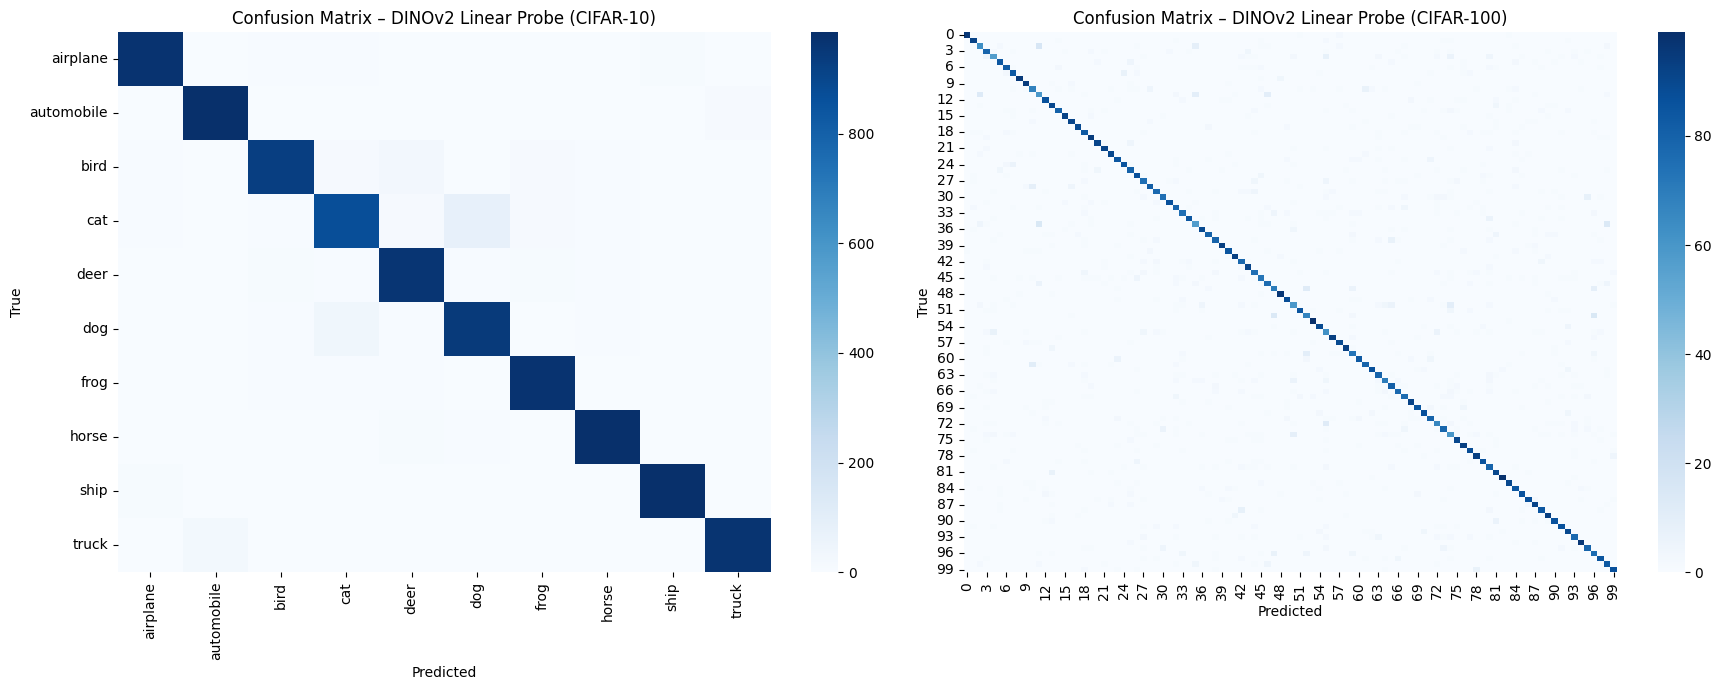

In [ ]:

cm10 = confusion_matrix(y_test_10, preds_10)
cm100 = confusion_matrix(y_test_100, preds_100)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CIFAR-10
sns.heatmap(
    cm10,
    ax=axes[0],
    cmap="Blues",
    xticklabels=train_set_10.classes,
    yticklabels=train_set_10.classes
)
axes[0].set_title("Confusion Matrix – DINOv2 Linear Probe (CIFAR-10)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# CIFAR-100
sns.heatmap(
    cm100,
    ax=axes[1],
    cmap="Blues",
    # xticklabels=train_set_100.classes,
    # yticklabels=train_set_100.classes
)
axes[1].set_title("Confusion Matrix – DINOv2 Linear Probe (CIFAR-100)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

## Predtrenirani DinoV2 na skupu Imagenette

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xvf imagenette2.tgz

Streaming output truncated to the last 5000 lines.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n03888257_18127.JP

In [ ]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [ ]:
from torchvision.datasets import ImageFolder

train_set_img = ImageFolder(
    root="imagenette2/train",
    transform=transform
)

test_set_img = ImageFolder(
    root="imagenette2/val",
    transform=transform
)

train_loader_img = torch.utils.data.DataLoader(
    train_set_img,
    batch_size=128,
    shuffle=False
)

test_loader_img = torch.utils.data.DataLoader(
    test_set_img,
    batch_size=128,
    shuffle=False
)

print("Imagenette classes:", train_set_img.classes)
print("Number of classes:", len(train_set_img.classes))

Imagenette classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Number of classes: 10


In [ ]:
X_train_img, y_train_img = extract_features(model, train_loader_img)
X_test_img, y_test_img = extract_features(model, test_loader_img)

np.save("X_train_img.npy", X_train_img)
np.save("y_train_img.npy", y_train_img)
np.save("X_test_img.npy", X_test_img)
np.save("y_test_img.npy", y_test_img)

print(X_train_img.shape, X_test_img.shape)

100%|██████████| 31/31 [00:46<00:00,  1.50s/it]

(9469, 384) (3925, 384)


**k-NN evaluation**

In [ ]:
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_img, y_train_img)
    preds_img = knn.predict(X_test_img)
    acc_img = accuracy_score(y_test_img, preds_img)
    print(f"Imagenette k-NN (k={k}) acc: {acc_img:.4f}")

Imagenette k-NN (k=1) acc: 0.9939
Imagenette k-NN (k=5) acc: 0.9957
Imagenette k-NN (k=10) acc: 0.9959
Imagenette k-NN (k=20) acc: 0.9954


**Linear probe**

In [ ]:
train_ds_img = torch.utils.data.TensorDataset(
    torch.tensor(X_train_img, dtype=torch.float32),
    torch.tensor(y_train_img, dtype=torch.long)
)

train_loader_img_lp = torch.utils.data.DataLoader(
    train_ds_img,
    batch_size=256,
    shuffle=True
)

In [ ]:
feature_dim = X_train_img.shape[1]
linear_img = LinearClassifier(feature_dim, 10).to(device)

optimizer_img = torch.optim.Adam(
    linear_img.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(25):
    linear_img.train()
    total_loss = 0

    for xb, yb in train_loader_img_lp:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_img.zero_grad()
        out = linear_img(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer_img.step()

        total_loss += loss.item()

    print(f"[Imagenette] Epoch {epoch+1}, loss = {total_loss / len(train_loader_img_lp):.4f}")

[Imagenette] Epoch 1, loss = 0.6330
[Imagenette] Epoch 2, loss = 0.0611
[Imagenette] Epoch 3, loss = 0.0379
[Imagenette] Epoch 4, loss = 0.0275
[Imagenette] Epoch 5, loss = 0.0210
[Imagenette] Epoch 6, loss = 0.0165
[Imagenette] Epoch 7, loss = 0.0134
[Imagenette] Epoch 8, loss = 0.0110
[Imagenette] Epoch 9, loss = 0.0092
[Imagenette] Epoch 10, loss = 0.0078
[Imagenette] Epoch 11, loss = 0.0067
[Imagenette] Epoch 12, loss = 0.0059
[Imagenette] Epoch 13, loss = 0.0052
[Imagenette] Epoch 14, loss = 0.0046
[Imagenette] Epoch 15, loss = 0.0042
[Imagenette] Epoch 16, loss = 0.0038
[Imagenette] Epoch 17, loss = 0.0034
[Imagenette] Epoch 18, loss = 0.0032
[Imagenette] Epoch 19, loss = 0.0029
[Imagenette] Epoch 20, loss = 0.0027
[Imagenette] Epoch 21, loss = 0.0025
[Imagenette] Epoch 22, loss = 0.0023
[Imagenette] Epoch 23, loss = 0.0022
[Imagenette] Epoch 24, loss = 0.0020
[Imagenette] Epoch 25, loss = 0.0019


In [ ]:
linear_img.eval()
with torch.no_grad():
    Xte_img = torch.tensor(X_test_img, dtype=torch.float32).to(device)
    preds_img = linear_img(Xte_img).argmax(dim=1).cpu().numpy()

acc_img = accuracy_score(y_test_img, preds_img)
print("Imagenette Linear probe accuracy:", acc_img)

Imagenette Linear probe accuracy: 0.9933757961783439


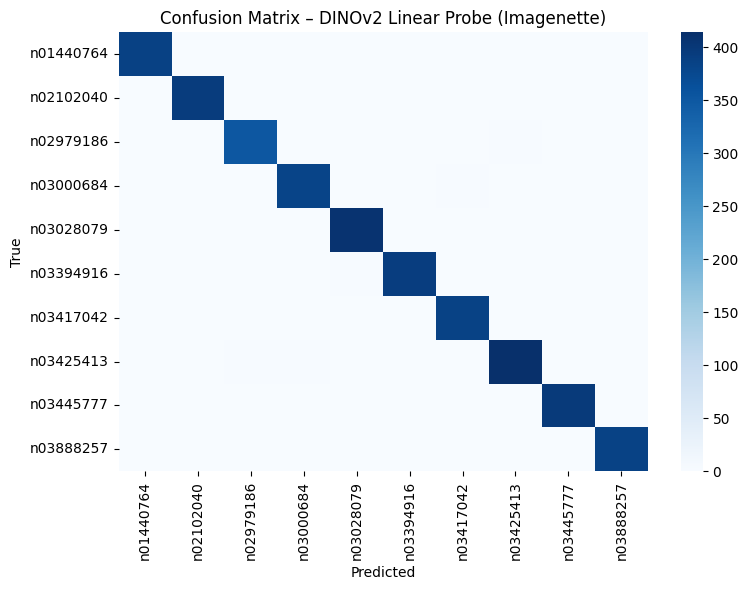

In [ ]:
cm_img = confusion_matrix(y_test_img, preds_img)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_img,
    cmap="Blues",
    xticklabels=train_set_img.classes,
    yticklabels=train_set_img.classes
)

plt.title("Confusion Matrix – DINOv2 Linear Probe (Imagenette)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

##Predtrenirani DinoV2 na skupu Tiny ImageNet

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

100%|██████████| 474M/474M [00:06<00:00, 75.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/akash2sharma/tiny-imagenet/versions/1


In [6]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [25]:
from torchvision.datasets import ImageFolder

tiny_root = path + "/tiny-imagenet-200"

train_set_tiny = ImageFolder(
    root=tiny_root + "/train",
    transform=transform
)

val_set_tiny = ImageFolder(
    root=tiny_root + "/val",
    transform=transform
)

train_loader_tiny = torch.utils.data.DataLoader(
    train_set_tiny, batch_size=128, shuffle=False
)

val_loader_tiny = torch.utils.data.DataLoader(
    val_set_tiny, batch_size=128, shuffle=False
)

print("Tiny ImageNet classes:", len(train_set_tiny.classes))

Tiny ImageNet classes: 200


In [26]:
X_train_tiny, y_train_tiny = extract_features(model, train_loader_tiny)
X_test_tiny, y_test_tiny = extract_features(model, val_loader_tiny)

print(X_train_tiny.shape, X_test_tiny.shape)

100%|██████████| 79/79 [01:03<00:00,  1.24it/s]

(100000, 384) (10000, 384)


**k-NN evaluation**

In [28]:
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_tiny, y_train_tiny)
    preds_tiny_knn = knn.predict(X_test_tiny)
    acc = accuracy_score(y_test_tiny, preds_tiny_knn)
    print(f"Tiny ImageNet k-NN (k={k}) acc: {acc:.4f}")

Tiny ImageNet k-NN (k=1) acc: 0.7699
Tiny ImageNet k-NN (k=5) acc: 0.7932
Tiny ImageNet k-NN (k=10) acc: 0.7997
Tiny ImageNet k-NN (k=20) acc: 0.8005


**Linear probe**

In [29]:
train_ds_tiny = torch.utils.data.TensorDataset(
    torch.tensor(X_train_tiny, dtype=torch.float32),
    torch.tensor(y_train_tiny, dtype=torch.long)
)

train_loader_tiny_lp = torch.utils.data.DataLoader(
    train_ds_tiny,
    batch_size=256,
    shuffle=True
)

In [32]:
feature_dim = X_train_tiny.shape[1]

linear_tiny = LinearClassifier(feature_dim, 200).to(device)

optimizer_tiny = torch.optim.Adam(
    linear_tiny.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()

In [33]:
for epoch in range(40):
    linear_tiny.train()
    total_loss = 0

    for xb, yb in train_loader_tiny_lp:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_tiny.zero_grad()
        outputs = linear_tiny(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer_tiny.step()

        total_loss += loss.item()

    print(f"[Tiny ImageNet] Epoch {epoch+1}, loss = {total_loss / len(train_loader_tiny_lp):.4f}")

[Tiny ImageNet] Epoch 1, loss = 1.1139
[Tiny ImageNet] Epoch 2, loss = 0.5986
[Tiny ImageNet] Epoch 3, loss = 0.5121
[Tiny ImageNet] Epoch 4, loss = 0.4624
[Tiny ImageNet] Epoch 5, loss = 0.4279
[Tiny ImageNet] Epoch 6, loss = 0.4032
[Tiny ImageNet] Epoch 7, loss = 0.3829
[Tiny ImageNet] Epoch 8, loss = 0.3679
[Tiny ImageNet] Epoch 9, loss = 0.3517
[Tiny ImageNet] Epoch 10, loss = 0.3415
[Tiny ImageNet] Epoch 11, loss = 0.3315
[Tiny ImageNet] Epoch 12, loss = 0.3220
[Tiny ImageNet] Epoch 13, loss = 0.3152
[Tiny ImageNet] Epoch 14, loss = 0.3069
[Tiny ImageNet] Epoch 15, loss = 0.3010
[Tiny ImageNet] Epoch 16, loss = 0.2953
[Tiny ImageNet] Epoch 17, loss = 0.2901
[Tiny ImageNet] Epoch 18, loss = 0.2861
[Tiny ImageNet] Epoch 19, loss = 0.2804
[Tiny ImageNet] Epoch 20, loss = 0.2771
[Tiny ImageNet] Epoch 21, loss = 0.2731
[Tiny ImageNet] Epoch 22, loss = 0.2701
[Tiny ImageNet] Epoch 23, loss = 0.2656
[Tiny ImageNet] Epoch 24, loss = 0.2624
[Tiny ImageNet] Epoch 25, loss = 0.2605
[Tiny Ima

In [34]:
linear_tiny.eval()
with torch.no_grad():
    Xte_tiny = torch.tensor(X_test_tiny, dtype=torch.float32).to(device)
    preds_tiny = linear_tiny(Xte_tiny).argmax(dim=1).cpu().numpy()

acc_tiny = accuracy_score(y_test_tiny, preds_tiny)
print("Linear probe accuracy Tiny ImageNet:", acc_tiny)

Linear probe accuracy Tiny ImageNet: 0.7953


**Results**

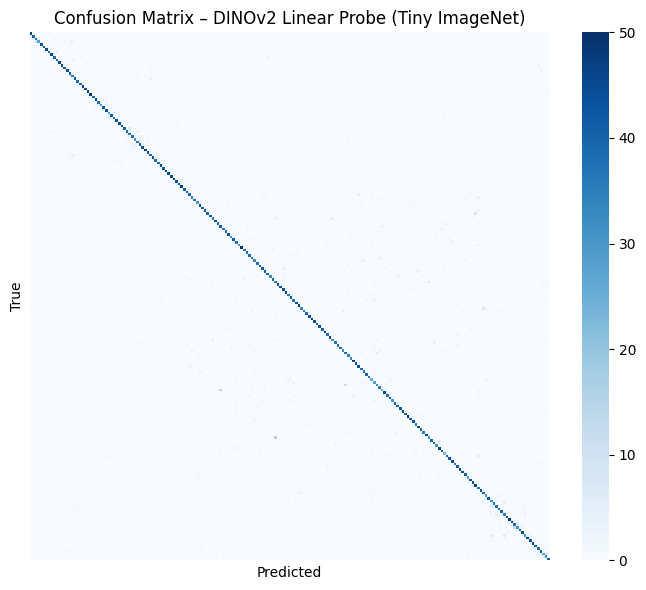

In [35]:
from sklearn.metrics import confusion_matrix

cm_tiny = confusion_matrix(y_test_tiny, preds_tiny)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_tiny,
    cmap="Blues",
    xticklabels=False,
    yticklabels=False
)
plt.title("Confusion Matrix – DINOv2 Linear Probe (Tiny ImageNet)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()